In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.utils import shuffle
import matplotlib.font_manager as fm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [100]:
def downsampling_data(df, target, val):
    desired_apriori=0.5

    # Get the indices per target value
    idx_val = df[df[target] == val].index
    idx_remain = df[df[target] != val].index

    remain = len(idx_remain)

    # Get original number of records per target value
    nb_val = len(df.loc[idx_val])

    # Calculate the undersampling rate and resulting number of records with target=0
    undersampling_rate = ((1-desired_apriori)*remain)/(nb_val*desired_apriori)
    undersampled_nb_val = int(undersampling_rate*nb_val)
    print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
    print('Number of records with target=B after undersampling: {}'.format(undersampled_nb_val))

    # Randomly select records with target=0 to get at the desired a priori
    undersampled_idx = shuffle(idx_val, random_state=37, n_samples=undersampled_nb_val)

    # Construct list with remaining indices
    idx_list = list(undersampled_idx) + list(idx_remain)

    downsampled_df = df.loc[idx_list].reset_index(drop=True)

    return downsampled_df

In [127]:
## 이상치 제거
def outliers_iqr(data):
    q1 = np.quantile(data, 0.25)
    q3 = np.quantile(data, 0.75)
    # 넘파이 값을 퍼센트로 표시해주는 함수
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)

    return np.where((data > upper_bound) | (data < lower_bound))

### OLS를 활용해 회귀분석

In [102]:
import warnings
warnings.filterwarnings('ignore')

In [103]:
jasan_df = pd.read_csv('./data/자산총계_최종.csv', index_col=0, dtype={'corp_code':'str', 'stock_code':'str'})
buchae_df = pd.read_csv('./data/부채총계_최종.csv', index_col=0, dtype={'corp_code':'str', 'stock_code':'str'})
jabon_df = pd.read_csv('./data/자본총계_최종.csv', index_col=0, dtype={'corp_code':'str', 'stock_code':'str'})
siga_df = pd.read_csv('./data/시가총액/시가총액_연평균.csv', index_col=0, dtype={'corp_code':'str', 'stock_code':'str'})
LEV = pd.read_csv('./data/LEV.csv', index_col=0, dtype={'corp_code':'str', 'stock_code':'str'})

In [104]:
LEV = pd.DataFrame()
for name in jasan_df['corp_name']:
    na_cnt =  jasan_df[jasan_df.corp_name == name].isnull().sum(axis=1).values[0]

    if na_cnt == 0:
        lev = buchae_df[buchae_df.corp_name == name].iloc[:, 4:].values / jasan_df[jasan_df.corp_name == name].iloc[:, 4:].values
        lev = pd.DataFrame(lev, columns = jasan_df.columns[4:])
    else:
        lev = buchae_df[buchae_df.corp_name == name].iloc[:, 4:-na_cnt].values / jasan_df[jasan_df.corp_name == name].iloc[:, 4:-na_cnt].values
        lev = pd.DataFrame(lev, columns = jasan_df.columns[4:-na_cnt])

    lev.insert(0, '종목명', name)
    LEV = pd.concat([LEV, lev])
LEV.reset_index(drop=True, inplace=True)

In [105]:
LEV_df = pd.DataFrame()
for i in LEV.columns[2:]:
    lev = LEV[['종목명', i]]
    lev.columns = ['종목명', 'LEV']
    lev['연도'] = i
    LEV_df = pd.concat([LEV_df, lev])

In [106]:
SIZE = np.log(jasan_df.iloc[:, 4:])
SIZE = pd.concat([jasan_df[['corp_name', 'stock_code']], SIZE], axis=1)
SIZE_df = pd.DataFrame()

for i in SIZE.columns[2:]:
    size = SIZE[['stock_code', 'corp_name', i]]
    size.columns = ['기업코드', '종목명', 'SIZE']
    size['연도'] = i
    SIZE_df = pd.concat([SIZE_df, size])

### 전처리

In [107]:
final_df = pd.read_csv('./data/최종데이터/최종데이터_ESG환산.csv', index_col=0)

In [108]:
final_df = final_df.replace("A+", 6).replace("A", 5).replace("B+", 4).replace("B", 3).replace("C", 2).replace("D", 1).replace("E", np.NaN)

In [109]:
LEV_df['연도'] = LEV_df['연도'].astype('int64')
SIZE_df['연도'] = SIZE_df['연도'].astype('int64')

In [110]:
LEV_df.head()

,종목명,LEV,연도
0,지역난방공사,0.702998,2020
1,아시아나IDT,0.364363,2020
2,현대약품,0.427684,2020
3,코스맥스,0.771329,2020
4,경인양행,0.547850,2020


In [111]:
final_df = pd.merge(final_df, LEV_df[['종목명', '연도', 'LEV']], on=['종목명', '연도'])
final_df = pd.merge(final_df, SIZE_df[['종목명', '연도', 'SIZE']], on=['종목명', '연도'])

In [112]:
final_df.dropna(axis=0, inplace=True)
final_df = final_df[final_df['누적수익률'] != 'np.NAN']
final_df['누적수익률'] = final_df['누적수익률'].astype('float')

In [113]:
final_df

,종목명,연도,누적수익률,종합등급,환경,사회,지배구조,ROA,ROE,tobinQ,코스피누적수익률,LEV,SIZE
1,AJ네트웍스,2016,-16.696604,3.0,2.0,3.0,3.0,0.820595,3.995265,0.756037,0.244437,0.794608,28.364022
2,AJ네트웍스,2017,-21.116001,3.0,3.0,3.0,3.0,0.877023,4.617270,0.719738,14.838077,0.810056,28.487236
3,AJ네트웍스,2018,-15.324073,3.0,2.0,3.0,3.0,1.447255,7.577926,0.574388,17.010852,0.809017,28.576925
4,AJ네트웍스,2019,-27.945367,3.0,1.0,3.0,3.0,2.336252,12.128881,0.651385,-8.843388,0.807381,28.220615
5,AJ네트웍스,2020,-37.503193,3.0,1.0,3.0,3.0,-0.208845,-1.151640,0.556895,-4.513591,0.818654,28.093604
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5740,후성,2016,92.884451,3.0,3.0,3.0,4.0,19.759910,38.586363,3.582117,0.244437,0.487904,26.462838
5741,후성,2017,132.717768,3.0,2.0,3.0,4.0,8.928117,13.509607,4.251250,14.838077,0.339128,26.479372
5742,후성,2018,59.411275,3.0,3.0,3.0,4.0,6.353841,11.426047,3.626249,17.010852,0.443916,26.813401
5743,후성,2019,-8.495724,3.0,3.0,2.0,3.0,0.038912,0.084715,3.073370,-8.843388,0.540669,26.994080


### 상관계수

In [115]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

<AxesSubplot:>

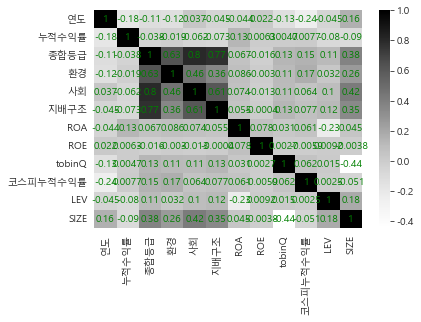

In [116]:
sns.heatmap(final_df.corr(), annot=True, annot_kws=dict(color='g'), cmap='Greys')


### 회귀분석

In [117]:
final_df.columns

Index(['종목명', '연도', '누적수익률', '종합등급', '환경', '사회', '지배구조', 'ROA', 'ROE',
       'tobinQ', '코스피누적수익률', 'LEV', 'SIZE'],
      dtype='object')

In [153]:
from statsmodels.formula.api import ols

In [152]:
res = ols('ROA ~ 연도+LEV+SIZE+ROE+tobinQ', data=final_df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    ROA   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     63.56
Date:                Sat, 14 May 2022   Prob (F-statistic):           9.45e-64
Time:                        20:28:25   Log-Likelihood:                -13778.
No. Observations:                3640   AIC:                         2.757e+04
Df Residuals:                    3634   BIC:                         2.761e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    565.9698    135.471      4.178      0.0

In [145]:
final_df.columns

Index(['종목명', '연도', '누적수익률', '종합등급', '환경', '사회', '지배구조', 'ROA', 'ROE',
       'tobinQ', '코스피누적수익률', 'LEV', 'SIZE'],
      dtype='object')

In [157]:
res = ols('ROE ~ 연도+LEV+누적수익률+ROA+코스피누적수익률', data=final_df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     5.602
Date:                Sat, 14 May 2022   Prob (F-statistic):           3.79e-05
Time:                        20:29:54   Log-Likelihood:                -25013.
No. Observations:                3640   AIC:                         5.004e+04
Df Residuals:                    3634   BIC:                         5.008e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4659.6592   3072.462     -1.517      0.1

In [148]:
res = ols('tobinQ ~ 환경+사회+지배구조+연도+LEV+SIZE+누적수익률+ROA+ROE+코스피누적수익률', data=final_df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 tobinQ   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     188.9
Date:                Sat, 14 May 2022   Prob (F-statistic):          3.37e-321
Time:                        20:26:57   Log-Likelihood:                -47393.
No. Observations:                3640   AIC:                         9.481e+04
Df Residuals:                    3629   BIC:                         9.488e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.367e+06   1.47e+06      1.607      0.1

In [144]:
res = ols('LEV ~ 종합등급+사회+환경+ROE+코스피누적수익률+tobinQ+SIZE+ROA', data=final_df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    LEV   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     56.37
Date:                Sat, 14 May 2022   Prob (F-statistic):           6.88e-87
Time:                        20:25:36   Log-Likelihood:                 659.50
No. Observations:                3640   AIC:                            -1301.
Df Residuals:                    3631   BIC:                            -1245.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3431      0.058     -5.883      0.0

In [126]:
final_df.describe()

,연도,누적수익률,종합등급,환경,사회,지배구조,ROA,ROE,tobinQ,코스피누적수익률,LEV,SIZE
count,3640.000000,3640.000000,3640.000000,3640.000000,3640.000000,3640.000000,3640.000000,3640.000000,3.640000e+03,3640.000000,3640.000000,3640.000000
mean,2016.014011,15.185732,3.170604,2.786264,3.321154,3.306319,2.306278,5.177681,1.014962e+04,3.819718,0.465914,27.074187
std,2.671143,69.663566,0.697236,0.940043,0.836376,0.740879,11.115825,234.356995,1.347011e+05,8.379020,0.214070,1.844436
min,2011.000000,-97.254766,1.000000,1.000000,1.000000,1.000000,-95.635348,-2818.284747,-6.131463e+01,-8.843388,0.024488,13.060203
25%,2014.000000,-23.553170,3.000000,2.000000,3.000000,3.000000,0.226852,0.546152,5.304646e-01,-1.211481,0.299303,26.060719
50%,2016.000000,-0.856072,3.000000,3.000000,3.000000,3.000000,2.473175,4.812300,8.471438e-01,2.619181,0.472989,26.944018
75%,2018.000000,32.889339,3.000000,3.000000,4.000000,4.000000,5.249178,9.275426,1.404138e+00,12.439058,0.615371,27.969631
max,2020.000000,812.227334,6.000000,6.000000,6.000000,6.000000,407.621431,13546.418464,3.053058e+06,17.010852,2.945354,33.566539


### 이상치 제거하기

In [128]:
outlier_cols = ['누적수익률', 'ROA', 'ROE', 'tobinQ', 'LEV', 'SIZE']
total_outliers = []
normal_index = []

for col in outlier_cols:
    outliers_index = outliers_iqr(final_df[col])[0]
    total_outliers.append(outliers_index)

total_outliers = [val for arr in total_outliers for val in arr]
print(len(total_outliers))

for i in final_df.index:
    if i not in total_outliers:
        normal_index.append(i)


1447


In [131]:
final_df_clean = final_df.loc[normal_index]
final_df_clean.describe()

,연도,누적수익률,종합등급,환경,사회,지배구조,ROA,ROE,tobinQ,코스피누적수익률,LEV,SIZE
count,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000
mean,2016.086137,3.838065,3.136784,2.771534,3.266543,3.282070,2.838117,4.878767,0.870910,3.911717,0.439111,27.139052
std,2.658784,37.025052,0.662664,0.910736,0.782298,0.712261,3.362666,5.983061,0.513885,8.485781,0.193024,1.356287
min,2011.000000,-97.254766,1.000000,1.000000,1.000000,1.000000,-7.001288,-12.381975,0.100569,-8.843388,0.024488,24.000482
25%,2014.000000,-23.001754,3.000000,2.000000,3.000000,3.000000,0.747990,1.514529,0.492247,-1.211481,0.278033,26.152208
50%,2016.000000,-2.494533,3.000000,3.000000,3.000000,3.000000,2.575558,4.898956,0.737202,2.619181,0.444279,26.958429
75%,2018.000000,24.987889,3.000000,3.000000,3.000000,4.000000,4.931728,8.549370,1.109303,12.439058,0.588472,27.898265
max,2020.000000,117.403831,6.000000,6.000000,6.000000,6.000000,12.775702,22.174749,2.714265,17.010852,0.944880,30.828749


In [132]:
res = ols('환경 ~ 코스피누적수익률+연도+LEV+SIZE+ROA+tobinQ', data=final_df_clean).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     환경   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     96.31
Date:                Sat, 14 May 2022   Prob (F-statistic):          5.77e-110
Time:                        20:22:27   Log-Likelihood:                -3322.3
No. Observations:                2705   AIC:                             6659.
Df Residuals:                    2698   BIC:                             6700.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     72.3859     12.508      5.787      0.0

In [136]:
res = ols('사회 ~ 코스피누적수익률+SIZE+ROA+tobinQ', data=final_df_clean).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     사회   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     292.5
Date:                Sat, 14 May 2022   Prob (F-statistic):          3.72e-209
Time:                        20:23:06   Log-Likelihood:                -2686.8
No. Observations:                2705   AIC:                             5384.
Df Residuals:                    2700   BIC:                             5413.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.3085      0.255    -20.787      0.0

In [134]:
res = ols('지배구조 ~ 코스피누적수익률+연도+SIZE+ROA+누적수익률+tobinQ', data=final_df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   지배구조   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     181.2
Date:                Sat, 14 May 2022   Prob (F-statistic):          2.58e-202
Time:                        20:22:55   Log-Likelihood:                -3596.3
No. Observations:                3640   AIC:                             7207.
Df Residuals:                    3633   BIC:                             7250.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.4289      8.617      4.575      0.0

In [151]:
res = ols('ROA ~ 연도+LEV+SIZE+ROE+tobinQ', data=final_df_clean).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    ROA   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     4467.
Date:                Sat, 14 May 2022   Prob (F-statistic):               0.00
Time:                        20:28:02   Log-Likelihood:                -4105.7
No. Observations:                2705   AIC:                             8223.
Df Residuals:                    2699   BIC:                             8259.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     61.6114     16.252      3.791      0.0

In [156]:
res = ols('ROE ~ 연도+LEV+누적수익률+ROA+코스피누적수익률', data=final_df_clean).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     3858.
Date:                Sat, 14 May 2022   Prob (F-statistic):               0.00
Time:                        20:29:37   Log-Likelihood:                -5839.8
No. Observations:                2705   AIC:                         1.169e+04
Df Residuals:                    2699   BIC:                         1.173e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -100.3654     32.826     -3.057      0.0

In [150]:
res = ols('tobinQ ~ 환경+사회+지배구조+연도+LEV+SIZE+누적수익률+ROA+ROE', data=final_df_clean).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 tobinQ   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     62.65
Date:                Sat, 14 May 2022   Prob (F-statistic):          1.13e-104
Time:                        20:27:29   Log-Likelihood:                -1779.9
No. Observations:                2705   AIC:                             3580.
Df Residuals:                    2695   BIC:                             3639.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -25.3512      7.252     -3.496      0.0

In [143]:
res = ols('LEV ~ 종합등급+사회+환경+ROE+코스피누적수익률+tobinQ+SIZE+ROA', data=final_df_clean).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    LEV   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     277.8
Date:                Sat, 14 May 2022   Prob (F-statistic):               0.00
Time:                        20:25:22   Log-Likelihood:                 1425.0
No. Observations:                2705   AIC:                            -2832.
Df Residuals:                    2696   BIC:                            -2779.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5022      0.062     -8.138      0.0